In [75]:
from keras.models import Model
from keras.layers import Input, Dense
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape



In [62]:
"""
-- Load data from analysis dataset --
"""

parent_folder_path = "images/analysis_dataset/"

categories = {}

# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

max_training = min(category_amount)

arrays = []
# convert the images into a pytorch dataset
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        if i >= max_training: break
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (100, 100):
            print(file_path, " IS NOT 250x250, it is: ", image.size)
            continue

        if image_array.shape != (250, 250):
            image_array = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

        arrays.append(image_array)

# Normalize the array of the normal 
arrays = arrays/ np.max(arrays)

arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * max_training

arrays_labels_normal = np.array(arrays_labels)


In [71]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.5, random_state=42, stratify=arrays_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)

"""
X_auto = np.array(X_auto)
X_auto = X_auto.reshape((len(X_auto), -1))

X_train = np.array(X_train)
X_train = X_train.reshape((len(X_train), -1))

X_test = np.array(X_test)
X_test = X_test.reshape((len(X_test), -1))

X = np.array(X)
X = X.reshape((len(X), -1))
"""

X_auto = X_auto.reshape((len(X_auto), 100, 100))
X_train = X_train.reshape((len(X_train), 100, 100))

X_test = X_test.reshape((len(X_test), 100, 100))


In [90]:

# definir la arquitectura del autoencoder

input_img = Input(shape=(100, 100, 1))
encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = Flatten()(encoded)
latent = Dense(150, activation='relu')(encoded)
decoded = Dense(2500, activation='relu')(latent)
decoded = Reshape((50, 50, 1))(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoded)

# Crear el modelo del autoencoder
autoencoder = Model(input_img, decoded)

# Compilar el modelo
optimizer = Adam(learning_rate = 0.01)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

print("Before fit autoencoder")

# Entrenar el autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=4,
                batch_size=256,
                shuffle=True,
                validation_data=(X, X))

print("after autoencoder")
# Obtener el vector latente (representación codificada)
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)



Before fit autoencoder
Epoch 1/4
86/86 [==============================] - 40s 462ms/step - loss: 0.6705 - val_loss: 0.6673
Epoch 2/4
86/86 [==============================] - 30s 355ms/step - loss: 0.6657 - val_loss: 0.6644
Epoch 3/4
86/86 [==============================] - 30s 345ms/step - loss: 0.6638 - val_loss: 0.6635
Epoch 4/4
86/86 [==============================] - 30s 349ms/step - loss: 0.6626 - val_loss: 0.6627
after autoencoder
103/103 [==============================] - 1s 9ms/step


103/103 [==============================] - 2s 15ms/step


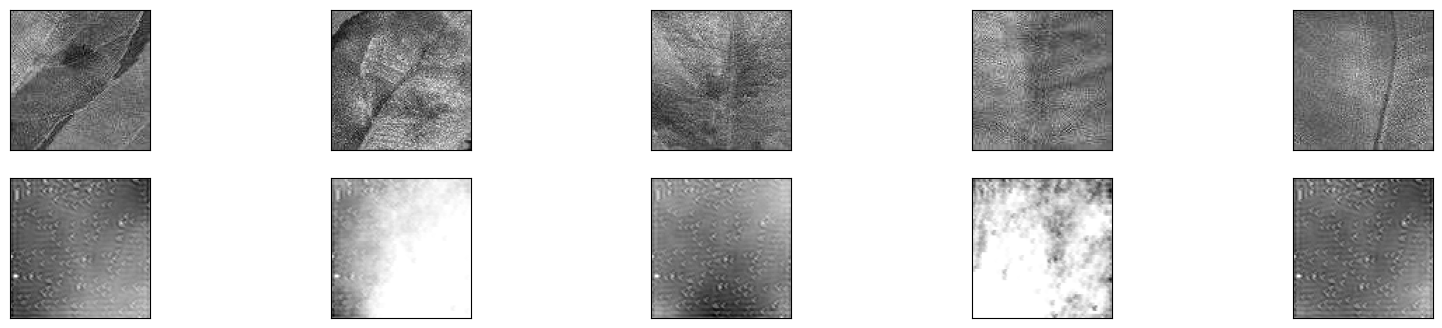

In [91]:
reconstructed_imgs = autoencoder.predict(X_test)

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [87]:
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=(150,))
output = Dense(128, activation='softmax')(input_latent)
output = Dense(64, activation='softmax')(input_latent)
output = Dense(38, activation='softmax')(input_latent)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = 0.0001)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=200,
               batch_size=256,
               validation_data=(encoded_test, y_test), verbose=1)

# Evaluar el rendimiento del clasificador en el conjunto de prueba
loss, accuracy = classifier.evaluate(encoded_test, y_test)
print("Pérdida de clasificación:", loss)
print("Exactitud de clasificación:", accuracy)

Epoch 1/200
73/73 [==============================] - 1s 6ms/step - loss: 3.6517 - accuracy: 0.0254 - val_loss: 3.6507 - val_accuracy: 0.0265
Epoch 2/200
73/73 [==============================] - 0s 3ms/step - loss: 3.6503 - accuracy: 0.0254 - val_loss: 3.6495 - val_accuracy: 0.0271
Epoch 3/200
73/73 [==============================] - 0s 4ms/step - loss: 3.6490 - accuracy: 0.0249 - val_loss: 3.6483 - val_accuracy: 0.0283
Epoch 4/200
73/73 [==============================] - 0s 4ms/step - loss: 3.6478 - accuracy: 0.0250 - val_loss: 3.6472 - val_accuracy: 0.0283
Epoch 5/200
73/73 [==============================] - 0s 3ms/step - loss: 3.6467 - accuracy: 0.0252 - val_loss: 3.6461 - val_accuracy: 0.0295
Epoch 6/200
73/73 [==============================] - 0s 3ms/step - loss: 3.6456 - accuracy: 0.0254 - val_loss: 3.6452 - val_accuracy: 0.0301
Epoch 7/200
73/73 [==============================] - 0s 3ms/step - loss: 3.6446 - accuracy: 0.0255 - val_loss: 3.6442 - val_accuracy: 0.0311
Epoch 8/200
7

KeyboardInterrupt: 